# Reconstruct Positions with UMAP

In this notebook, we demonstrate how UMAP can be used to reconstruct positions at single cell resolution on the simulated data. We provide examples of reconstructions on a uniform grid and ground-truth positions from the Slide-seq kidney dataset and the method with diffusion from simulated bacterial colonies described in the supplement.

In [1]:
import anndata
import umap
import sys
import numpy as np
import sklearn
from matplotlib import pyplot as plt

sys.path.append("../functions/")
import alignment
import visuals

In [2]:
# Set parameters
SAMPLE = 'kidney_140rpb' # Read per bead distribution, cacluated from Slide-seq samples
SATELLITES_PER_CM2 = 10**5        # Satellites per cm2
SIGMA_UM = 50            # Width of the diffusion kernel
BEADWIDTH_UM = 10        # Beadwidth in um
SEED = 0                 # Random seed for the numpy number generator

### Uniform Grid

In [3]:
# Load the data
adata = anndata.read_h5ad('../data/adata/{}_satellites={}_sigma={}.h5ad'.format(SAMPLE, SATELLITES_PER_CM2, SIGMA_UM))
BEADS_PER_EDGE = np.sqrt(adata.shape[0])
EDGE_WIDTH = BEADS_PER_EDGE*BEADWIDTH_UM

First, we row-normalize the data so that cell $[i,j]$ represents the proportion of reads for bead $i$ that come from satellite $j$. This makes the read vectors similar for nearby beads that differed in bead quality. We then pass the normalized coordinates to UMAP, using the Euclidean distance and hyperparameters that were selected using a simple grid search. See the supplement for more information on hyperparameter selection. 

Instead of row-normalizing the data and using the Euclidean distance, you can try using the cosine similarity which only depends on the angle between the vectors. However, in experiments we found that normalizing and using the Euclidean distance resulted in marginally better reconstructions.

In [4]:
# Normalize the data and run UMAP
adata.X = sklearn.preprocessing.normalize(adata.X, norm='l1')
mapper = umap.UMAP(n_neighbors=60, metric='euclidean', random_state=SEED, n_epochs=5000, min_dist=0.75, unique=True, verbose=True)
coords = mapper.fit_transform(adata.X)

UMAP(min_dist=0.75, n_epochs=5000, n_neighbors=60, random_state=0, unique=True,
     verbose=True)


/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


Unique=True -> Number of data points reduced from  99856  to  99812
Most common duplicate is 61680  with a count of  3
Construct fuzzy simplicial set
Thu Aug 25 10:02:21 2022 Finding Nearest Neighbors
Thu Aug 25 10:02:21 2022 Building RP forest with 21 trees
Thu Aug 25 10:05:50 2022 metric NN descent for 17 iterations
	 0  /  17
	 1  /  17
Thu Aug 25 10:10:31 2022 Finished Nearest Neighbor Search
Thu Aug 25 10:10:35 2022 Construct embedding
	completed  0  /  5000 epochs
	completed  500  /  5000 epochs
	completed  1000  /  5000 epochs
	completed  1500  /  5000 epochs
	completed  2000  /  5000 epochs
	completed  2500  /  5000 epochs
	completed  3000  /  5000 epochs
	completed  3500  /  5000 epochs
	completed  4000  /  5000 epochs
	completed  4500  /  5000 epochs
Thu Aug 25 11:07:42 2022 Finished embedding


Since the sBC counts only give information about relative position, the embedding may be translated, shrunken, expanded, rotated, or flipped relative to the ground truth. To compare to the ground truth, we optimize for the best alignment of a simple linear transformation of the embedding. 

In [5]:
# Align the UMAP with the ground-truth using a simple linear transformation
ground_truth = np.array([adata.obs.x, adata.obs.y]).T
dist_gt, aligned_coords, transf = alignment.align(coords, ground_truth)

Finally, we can compare the reconstruction to the ground truth. First, we visualize the reconstruction showing the ground truth coordinates (left) and the reconstruction (center) on a colored background with radial lines and with beads colored by distance to the ground truth (right). Second, we visualize the complementary cumulative distribution, or the proportion of beads with a reconstruction distance beyond a given distance with dashed lines indicating 50% and 90% of beads having a reconstruction distance below that value. For the example parameters, 50% of beads are within 18 $\mu m$ of the ground truth while 90% are within 40 $\mu m$.

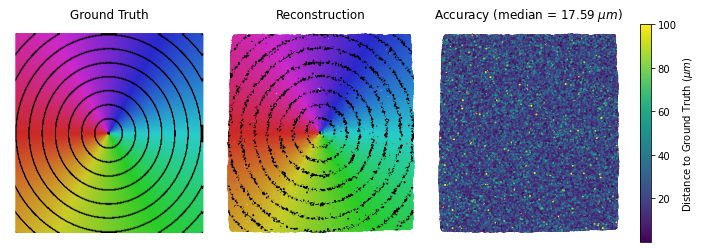

In [6]:
# Visually compare the reconstruction to the ground truth
visuals.ground_truth_comparison(adata, aligned_coords, dist_gt)

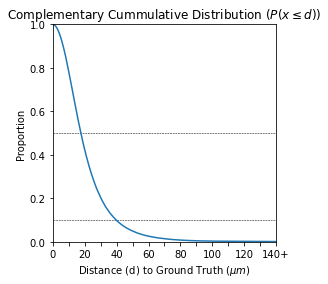

In [7]:
# Plot the complementary cummulative distribution
visuals.complementary_cummulative_distribution(dist_gt, max_dist=140)

### Slide-seq Kidney Positions

Here we repeat the reconstruction for the simulated data using ground-truth positions from the Slide-seq kidney sample.

In [8]:
# Load the data
adata = anndata.read_h5ad('../data/adata/{}_satellites={}_sigma={}_slideseq_kidney_positions.h5ad'.format(SAMPLE, SATELLITES_PER_CM2, SIGMA_UM))
EDGE_WIDTH = max(max(adata.obs.x) - min(adata.obs.x), max(adata.obs.y) - min(adata.obs.y))

In [10]:
# Normalize the data and run UMAP
adata.X = sklearn.preprocessing.normalize(adata.X, norm='l1')
mapper = umap.UMAP(n_neighbors=60, metric='euclidean', random_state=SEED, n_epochs=5000, min_dist=0.75, unique=True, 
                   verbose=True)
coords = mapper.fit_transform(adata.X)

UMAP(min_dist=0.75, n_epochs=5000, n_neighbors=60, random_state=0, unique=True,
     verbose=True)


/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


Unique=True -> Number of data points reduced from  30758  to  30575
Most common duplicate is 165  with a count of  163
Construct fuzzy simplicial set
Thu Aug 25 11:08:58 2022 Finding Nearest Neighbors
Thu Aug 25 11:08:58 2022 Building RP forest with 14 trees
Thu Aug 25 11:09:26 2022 metric NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
Thu Aug 25 11:10:53 2022 Finished Nearest Neighbor Search
Thu Aug 25 11:10:54 2022 Construct embedding
	completed  0  /  5000 epochs
	completed  500  /  5000 epochs
	completed  1000  /  5000 epochs
	completed  1500  /  5000 epochs
	completed  2000  /  5000 epochs
	completed  2500  /  5000 epochs
	completed  3000  /  5000 epochs
	completed  3500  /  5000 epochs
	completed  4000  /  5000 epochs
	completed  4500  /  5000 epochs
Thu Aug 25 11:27:36 2022 Finished embedding


In [11]:
# Align the UMAP with the ground-truth using a simple linear transformation
ground_truth = np.array([adata.obs.x, adata.obs.y]).T
dist_gt, aligned_coords, transf = alignment.align(coords, ground_truth)

Again, we can compare the results visually and quantitatively. Using the default parameters, we see a degradation of ~13 $\mu m$ in the median reconstruction distance compared to the dense grid. This is likely a conservative estimate of reconstruction performance, as beads without tissue reads have been removed from the dataset, leaving holes in the sample which increase the difficulty of reconstruction. In practice, even beads without tissue reads would receive sBCs, simplifying the reconstruction task.

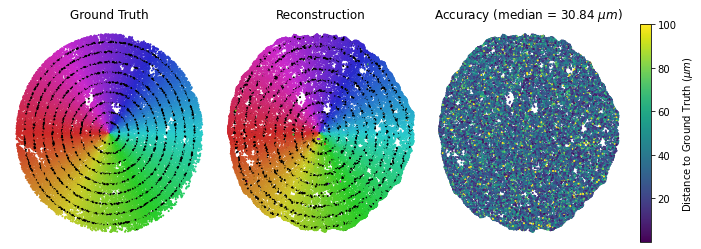

In [12]:
# Visually compare the reconstruction to the ground truth
visuals.ground_truth_comparison(adata, aligned_coords, dist_gt)

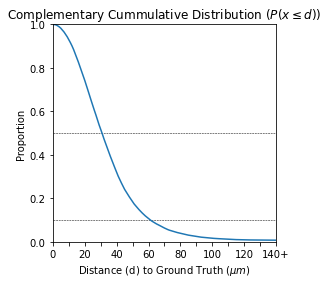

In [13]:
# Plot the complementary cummulative distribution
visuals.complementary_cummulative_distribution(dist_gt, max_dist=140)

### Bacterial Colonies as Satellites

Here we demonstrate reconstructions on data generated using simulated e.Coli colonies as satellite devices instead of point sources.

In [14]:
# Load the data
adata = anndata.read_h5ad('../data/adata/{}_satellites={}_sigma={}_irregular_colonies.h5ad'.format(SAMPLE, SATELLITES_PER_CM2, SIGMA_UM))
BEADS_PER_EDGE = np.sqrt(adata.shape[0])
EDGE_WDITH = BEADS_PER_EDGE*BEADWIDTH_UM

In [15]:
# Normalize the data and run UMAP
adata.X = sklearn.preprocessing.normalize(adata.X, norm='l1')
mapper = umap.UMAP(n_neighbors=60, metric='euclidean', random_state=SEED, n_epochs=5000, min_dist=0.75, unique=True, verbose=True)
coords = mapper.fit_transform(adata.X)

UMAP(min_dist=0.75, n_epochs=5000, n_neighbors=60, random_state=0, unique=True,
     verbose=True)


/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


Unique=True -> Number of data points reduced from  99856  to  99789
Most common duplicate is 93826  with a count of  3
Construct fuzzy simplicial set
Thu Aug 25 11:27:41 2022 Finding Nearest Neighbors
Thu Aug 25 11:27:41 2022 Building RP forest with 21 trees
Thu Aug 25 11:30:53 2022 metric NN descent for 17 iterations
	 0  /  17
	 1  /  17
Thu Aug 25 11:35:09 2022 Finished Nearest Neighbor Search
Thu Aug 25 11:35:11 2022 Construct embedding
	completed  0  /  5000 epochs
	completed  500  /  5000 epochs
	completed  1000  /  5000 epochs
	completed  1500  /  5000 epochs
	completed  2000  /  5000 epochs
	completed  2500  /  5000 epochs
	completed  3000  /  5000 epochs
	completed  3500  /  5000 epochs
	completed  4000  /  5000 epochs
	completed  4500  /  5000 epochs
Thu Aug 25 12:29:41 2022 Finished embedding


In [16]:
# Align the UMAP with the ground-truth using a simple linear transformation
ground_truth = np.array([adata.obs.x, adata.obs.y]).T
dist_gt, aligned_coords, transf = alignment.align(coords, ground_truth)

For the default parameters, we see a very slight increase in performance simulating diffusion with simulated bacterial colonies instead of point sources. However, as discussed in the supplement, we achieve the best reconstructions using the baseline diffusion method.

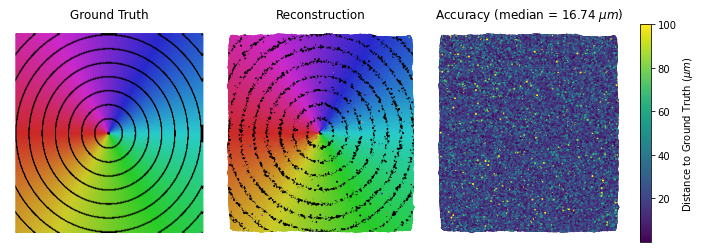

In [17]:
# Visually compare the reconstruction to the ground truth
visuals.ground_truth_comparison(adata, aligned_coords, dist_gt)

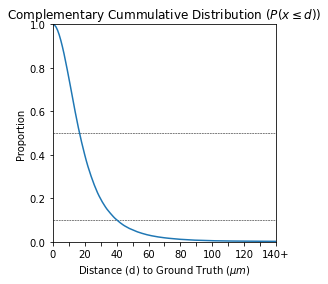

In [18]:
# Plot the complementary cummulative distribution
visuals.complementary_cummulative_distribution(dist_gt, max_dist=140)